# **Data Diri**
* Nama Lengkap: Chris Tianto Pratama
* Username: chrix0n
* Email: christiantopratama@gmail.com



---



# **Import**


---



In [ ]:
!pip install scikit-surprise

In [ ]:
import pandas as pd
import numpy as np 
from zipfile import ZipFile
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import seaborn as sns
from pathlib import Path
import matplotlib.pyplot as plt
import statistics
import itertools

from collections import defaultdict
from surprise.model_selection import GridSearchCV
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from surprise import Dataset, SVD, KNNBasic, KNNBaseline, NMF, SlopeOne, Reader
from surprise.model_selection import cross_validate
from surprise.model_selection import train_test_split
from collections import Counter

In [ ]:
sns.set()

# **Data Loading**


---



Link halaman dataset MovieLens: https://grouplens.org/datasets/movielens/

Link download dataset MovieLens (Small): https://files.grouplens.org/datasets/movielens/ml-latest-small.zip

In [ ]:
!wget https://files.grouplens.org/datasets/movielens/ml-latest-small.zip

--2022-11-30 17:00:54--  https://files.grouplens.org/datasets/movielens/ml-latest-small.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 978202 (955K) [application/zip]
Saving to: ‘ml-latest-small.zip’

ml-latest-small.zip 100%[===================>] 955.28K  --.-KB/s    in 0.1s    

2022-11-30 17:00:54 (8.18 MB/s) - ‘ml-latest-small.zip’ saved [978202/978202]



In [ ]:
!unzip /content/ml-latest-small.zip

Archive:  /content/ml-latest-small.zip
   creating: ml-latest-small/
  inflating: ml-latest-small/links.csv  
  inflating: ml-latest-small/tags.csv  
  inflating: ml-latest-small/ratings.csv  
  inflating: ml-latest-small/README.txt  
  inflating: ml-latest-small/movies.csv  


Dataset ini berisi kumpulan subdataset, yaitu:
- movies (data film)
- ratings (data rating oleh pengguna)
- links (link sumber data film)
- tags (tag yang diberikan oleh pengguna terhadap film)

In [ ]:
movies = pd.read_csv('/content/ml-latest-small/movies.csv')
ratings = pd.read_csv('/content/ml-latest-small/ratings.csv')
links = pd.read_csv('/content/ml-latest-small/links.csv')
tags = pd.read_csv('/content/ml-latest-small/tags.csv')

Dataset yang akan digunakan dalam proyek ini:
- movies
- ratings



In [ ]:
movies

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9739,193585,Flint (2017),Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation


In [ ]:
ratings

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


# **Data Understanding (Exploratory Data Analysis)**


---



**1. Deskripsi Variabel**

**Movies**



| Nama fitur | Deskripsi | Tipe data |
|---|---|---|
|movieId| ID dari film berdasarkan website [TMDB](https://www.themoviedb.org) |int64|
|title| Judul film |object|
|genres| Genre film, yang dipisah dengan tanda pipe ('\|') |object|

Jumlah data pada dataset movies: 9742

In [ ]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


**Ratings**

| Nama fitur | Deskripsi | Tipe data |
|---|---|---|
|userId| ID dari pengguna website MovieLens yang memberikan rating|int64|
|movieId| ID dari film yang diberi rating |int64|
|rating| Nilai yang diberikan dalam skala 0.5 - 5, dengan peningkatan nilai sebesar 0.5 |float64|
|timestamp| Waktu pemberian rating dalam satuan detik |int64|

Jumlah data pada dataset ratings: 100836

In [ ]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


Fitur timestamp tidak digunakan dalam pemberian rekomendasi, sehingga fitur tersebut dihapus dalam dataset ratings.

In [ ]:
ratings = ratings.drop('timestamp', axis=1)

In [ ]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   userId   100836 non-null  int64  
 1   movieId  100836 non-null  int64  
 2   rating   100836 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 2.3 MB


**2. Pemeriksaan Missing Value**

Movies

In [ ]:
movies.isnull().sum()

movieId    0
title      0
genres     0
dtype: int64

Rating

In [ ]:
ratings.isnull().sum()

userId     0
movieId    0
rating     0
dtype: int64

Tidak ada data dengan missing value pada dataset movies dan ratings

**3. Univariate Analysis**

**3.1 Movies**


**Fitur movieID**

In [ ]:
print('Jumlah movieID unik: ', len(movies.movieId.unique()))

Jumlah movieID unik:  9742


Terdapat 9742 movie ID unik dalam dataset movies. Jumlah movieID unik sama dengan jumlah data pada dataset movies, sehingga dapat dipastikan bahwa setiap data memiliki movie ID yang berbeda.

**Fitur title**

In [ ]:
print('Jumlah title unik: ', len(movies.title.unique()))

Jumlah title unik:  9737


Terdapat 9737 judul film unik dalam dataset movies. Jumlah title unik lebih sedikit daripada jumlah data pada dataset movies. Hal ini menunjukkan bahwa terdapat 5 judul duplikat.


**Fitur genre**

In [ ]:
print('Jumlah genre: ', len(movies.genres.unique()))

Jumlah genre:  951


Genre yang tersedia

In [ ]:
movies['genres'].value_counts()

Drama                                                  1053
Comedy                                                  946
Comedy|Drama                                            435
Comedy|Romance                                          363
Drama|Romance                                           349
                                                       ... 
Action|Crime|Horror|Mystery|Thriller                      1
Adventure|Animation|Children|Comedy|Musical|Romance       1
Action|Adventure|Animation|Comedy|Crime|Mystery           1
Children|Comedy|Fantasy|Sci-Fi                            1
Action|Animation|Comedy|Fantasy                           1
Name: genres, Length: 951, dtype: int64

Data dengan genre lebih dari satu terlihat dipisah dengan tanda " | ". Untuk mendapatkan genre-genre tersebut secara terpisah, semua nilai dalam kolom genre diubah menjadi array yang berisi string, lalu hitung jumlah kemunculan genre.

In [ ]:
movies['genres']= movies['genres'].str.split("|")

In [ ]:
movies['genres']

0       [Adventure, Animation, Children, Comedy, Fantasy]
1                          [Adventure, Children, Fantasy]
2                                       [Comedy, Romance]
3                                [Comedy, Drama, Romance]
4                                                [Comedy]
                              ...                        
9737                 [Action, Animation, Comedy, Fantasy]
9738                         [Animation, Comedy, Fantasy]
9739                                              [Drama]
9740                                  [Action, Animation]
9741                                             [Comedy]
Name: genres, Length: 9742, dtype: object

In [ ]:
flat_list = list(itertools.chain(*movies['genres']))
counter_of_flat_list = Counter(flat_list)
genre_stat = pd.DataFrame(counter_of_flat_list.most_common(), columns=['Genre', 'Jumlah data'])
genre_stat  

,Genre,Jumlah data
0,Drama,4361
1,Comedy,3756
2,Thriller,1894
3,Action,1828
4,Romance,1596
5,Adventure,1263
6,Crime,1199
7,Sci-Fi,980
8,Horror,978
9,Fantasy,779


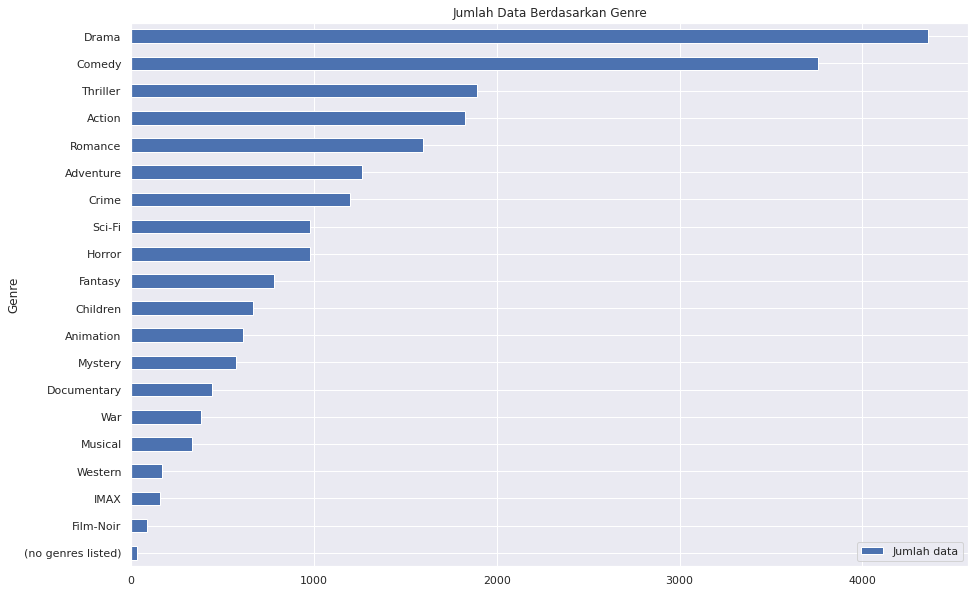

In [ ]:
genre_stat.head(20).set_index('Genre').sort_values(ascending=True, by="Jumlah data").plot(kind='barh', title="Jumlah Data Berdasarkan Genre", figsize=[15,10])

plt.show()

In [ ]:
genre_stat['persentase'] = ((genre_stat['Jumlah data'] / genre_stat['Jumlah data'].sum()) * 100).round(2)
genre_stat

,Genre,Jumlah data,persentase
0,Drama,4361,19.75
1,Comedy,3756,17.01
2,Thriller,1894,8.58
3,Action,1828,8.28
4,Romance,1596,7.23
5,Adventure,1263,5.72
6,Crime,1199,5.43
7,Sci-Fi,980,4.44
8,Horror,978,4.43
9,Fantasy,779,3.53


Fitur rating terdiri atas 19 nilai unik, yaitu Drama, Comedy, Thriller, Action, Romance, Adventure, Crime, Sci-Fi, Horror, Fantasy, Children, Animation, Mystery, Documentary, War, Musical, Western, IMAX, Film-Noir, dan genre kosong (no genres listed). Genre dengan jumlah film terbanyak di dalam dataset adalah Drama.

**3.2 Ratings**


**Fitur userId**

In [ ]:
print('Jumlah userId unik: ', len(ratings.userId.unique()))

Jumlah userId unik:  610


Terdapat 610 userId pada dataset ratings. Hal ini menunjukkan bahwa 610 pengguna secara keseluruhan telah membuat 100836 rating.

In [ ]:
ratings.userId.value_counts().to_frame(name="Jumlah rating")

,Jumlah rating
414,2698
599,2478
474,2108
448,1864
274,1346
...,...
442,20
569,20
320,20
576,20


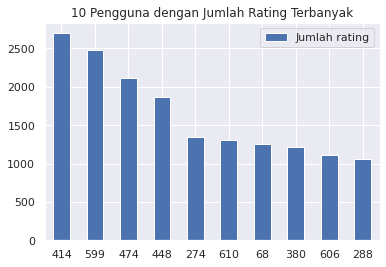

In [ ]:
ratings.userId.value_counts().to_frame(name="Jumlah rating").head(10).plot(kind="bar", title="10 Pengguna dengan Jumlah Rating Terbanyak", rot= 0)

Stastistik deskriptif jumlah pemberian rating setiap pengguna.

In [ ]:
ratings.userId.value_counts().to_frame(name="Jumlah rating").describe()

,Jumlah rating
count,610.000000
mean,165.304918
std,269.480584
min,20.000000
25%,35.000000
50%,70.500000
75%,168.000000
max,2698.000000


Pengguna yang memberikan rating terbanyak adalah pengguna dengan userId 414, yang telah membuat 2698 rating. Pengguna dengan jumlah rating yang paling sedikit dalam dataset ini adalah 20.

**Fitur movieId**

In [ ]:
print('Jumlah movieId unik yang diberi rating: ', len(ratings.movieId.unique()))

Jumlah movieId unik yang diberi rating:  9724


Terdapat 9724 movieId pada dataset rating. Jumlah film yang dirating tidak sama dengan jumlah film keseluruhan pada dataset movies sebelum penghapusan data (9742 movieID). Hal ini menunjukkan bahwa terdapat film yang belum diberi rating.

**Fitur rating**

In [ ]:
print('Jumlah kemungkinan pemberian rating: ', len(ratings.rating.unique()))

Jumlah kemungkinan pemberian rating:  10


In [ ]:
ratings.rating.unique()

array([4. , 5. , 3. , 2. , 1. , 4.5, 3.5, 2.5, 0.5, 1.5])

Terdapat 10 kemungkinan nilai yang dapat diberikan dalam pemberian rating, yaitu 5.0, 4.5, 4.0, 3.5, 3.0, 2.5, 2.0, 1.5, 1.0, dan 0.5. Hal ini menunjukkan bahwa skala rating yang digunakan adalah 0.5 - 5.0.

In [ ]:
ratings.rating.value_counts().sort_index().to_frame(name="Jumlah data berdasarkan rating")

,Jumlah data berdasarkan rating
0.5,1370
1.0,2811
1.5,1791
2.0,7551
2.5,5550
3.0,20047
3.5,13136
4.0,26818
4.5,8551
5.0,13211


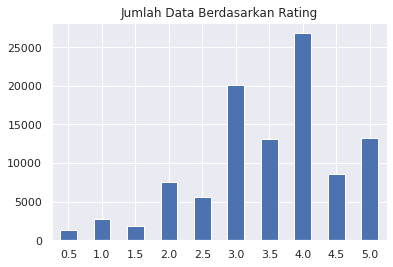

In [ ]:
ratings.rating.value_counts().sort_index().plot(kind="bar", title="Jumlah Data Berdasarkan Rating", rot=0)

Grafik di atas menunjukkan jumlah data berdasarkan rating dari yang terbanyak hingga yang paling sedikit. Jumlah data terbanyak adalah data yang memberikan rating 4.0, sedangkan jumlah data paling sedikit adalah data yang memberikan rating 0.5.

# **Data Preparation**

**1. Penanganan judul film duplikat pada dataset movies**

Pada tahap ini, data film dengan judul duplikat akan dihapus. Tahap ini bertujuan untuk mencegah pemberian dua rekomendasi film yang sama oleh model Content Based Filtering dan Collaborative Filtering.

In [ ]:
judul = movies['title'].value_counts()
judul_duplikat = judul[judul > 1].to_frame().reset_index()
judul_duplikat.columns = ['title', 'jumlah data']

judul_duplikat

,title,jumlah data
0,Emma (1996),2
1,War of the Worlds (2005),2
2,Confessions of a Dangerous Mind (2002),2
3,Eros (2004),2
4,Saturn 3 (1980),2


In [ ]:
movies[movies.duplicated(keep=False, subset=['title'])]

,movieId,title,genres
650,838,Emma (1996),"[Comedy, Drama, Romance]"
2141,2851,Saturn 3 (1980),"[Adventure, Sci-Fi, Thriller]"
4169,6003,Confessions of a Dangerous Mind (2002),"[Comedy, Crime, Drama, Thriller]"
5601,26958,Emma (1996),[Romance]
5854,32600,Eros (2004),[Drama]
5931,34048,War of the Worlds (2005),"[Action, Adventure, Sci-Fi, Thriller]"
6932,64997,War of the Worlds (2005),"[Action, Sci-Fi]"
9106,144606,Confessions of a Dangerous Mind (2002),"[Comedy, Crime, Drama, Romance, Thriller]"
9135,147002,Eros (2004),"[Drama, Romance]"
9468,168358,Saturn 3 (1980),"[Sci-Fi, Thriller]"


Salah satu judul film duplikat akan dihapus.

In [ ]:
movies.drop_duplicates('title', keep='last')

,movieId,title,genres
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]"
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]"
2,3,Grumpier Old Men (1995),"[Comedy, Romance]"
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]"
4,5,Father of the Bride Part II (1995),[Comedy]
...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),"[Action, Animation, Comedy, Fantasy]"
9738,193583,No Game No Life: Zero (2017),"[Animation, Comedy, Fantasy]"
9739,193585,Flint (2017),[Drama]
9740,193587,Bungo Stray Dogs: Dead Apple (2018),"[Action, Animation]"


In [ ]:
movies = movies.drop_duplicates('title', keep='last')

In [ ]:
movies[movies.duplicated(keep=False, subset=['title'])]

,movieId,title,genres


In [ ]:
movies.shape

(9737, 3)

Data dengan judul film duplikat telah dihapus. Jumlah data telah berkurang dari 9742 menjadi 9737.

**2. Penanganan terhadap data film yang memiliki tidak memiliki genre pada dataset movies**

Pada tahap ini, semua data film yang memiliki genre kosong (*no genres listed*) akan dihapus. 34 data dengan genre kosong (no genres listed) perlu dihapus dalam dataset movies. Tahap ini bertujuan untuk mencegah pemberian rekomendasi film tanpa genre kepada pengguna oleh model Content Based Filtering, karena ada kemungkinan bahwa film yang direkomendasikan tidak sesuai dengan preferensi pengguna.

In [ ]:
movies[movies.genres.str.contains('(no genres listed)', regex=False)]

,movieId,title,genres
8517,114335,La cravate (1957),[(no genres listed)]
8684,122888,Ben-hur (2016),[(no genres listed)]
8687,122896,Pirates of the Caribbean: Dead Men Tell No Tal...,[(no genres listed)]
8782,129250,Superfast! (2015),[(no genres listed)]
8836,132084,Let It Be Me (1995),[(no genres listed)]
8902,134861,Trevor Noah: African American (2013),[(no genres listed)]
9033,141131,Guardians (2016),[(no genres listed)]
9053,141866,Green Room (2015),[(no genres listed)]
9070,142456,The Brand New Testament (2015),[(no genres listed)]
9091,143410,Hyena Road,[(no genres listed)]


In [ ]:
movies = movies[~(movies.genres.str.contains('(no genres listed)', regex=False))]

In [ ]:
movies

,movieId,title,genres
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]"
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]"
2,3,Grumpier Old Men (1995),"[Comedy, Romance]"
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]"
4,5,Father of the Bride Part II (1995),[Comedy]
...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),"[Action, Animation, Comedy, Fantasy]"
9738,193583,No Game No Life: Zero (2017),"[Animation, Comedy, Fantasy]"
9739,193585,Flint (2017),[Drama]
9740,193587,Bungo Stray Dogs: Dead Apple (2018),"[Action, Animation]"


Data dengan genre '(no genres listed)' telah dihapus. Jumlah data telah berkurang dari 9737 menjadi 9703.

**3. Penggabungan dataset movies dengan ratings**



Pada tahap ini, data movies dan ratings akan digabungkan berdasarkan movieId. Tahap ini bertujuan untuk menunjukkan data film yang belum memiliki rating dan mempersiapkan data sebelum melakukan pelatihan model Content Based Filtering.

In [ ]:
movie_ratings = pd.merge(movies, ratings, on='movieId', how='left')

In [ ]:
movie_ratings

,movieId,title,genres,userId,rating
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",1.0,4.0
1,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",5.0,4.0
2,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",7.0,4.5
3,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",15.0,2.5
4,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",17.0,4.5
...,...,...,...,...,...
100702,193581,Black Butler: Book of the Atlantic (2017),"[Action, Animation, Comedy, Fantasy]",184.0,4.0
100703,193583,No Game No Life: Zero (2017),"[Animation, Comedy, Fantasy]",184.0,3.5
100704,193585,Flint (2017),[Drama],184.0,3.5
100705,193587,Bungo Stray Dogs: Dead Apple (2018),"[Action, Animation]",184.0,3.5


**4. Penanganan terhadap data film yang belum memiliki rating**

Pada tahap ini, data yang belum memiliki rating pada dataset gabungan movies dan ratings akan dihapus. Tahap ini bertujuan untuk mencegah pemberian rekomendasi film yang belum memiliki rating oleh model Collaborative Filtering.

In [ ]:
rating_mean = movie_ratings.groupby('title')['movieId','title','rating'].mean().round(2).sort_values(ascending = False, by='rating')
rating_mean['movieId']= rating_mean['movieId'].astype(np.int64) # movieId diubah dari float64 menjadi int64
rating_mean 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


,movieId,rating
title,,
Karlson Returns (1970),172585,5.0
Enter the Void (2009),78836,5.0
English Vinglish (2012),99636,5.0
Empties (2007),173963,5.0
Tenchi Muyô! In Love (1996),157775,5.0
...,...,...
"Road Home, The (Wo de fu qin mu qin) (1999)",6668,NaN
"Roaring Twenties, The (1939)",25855,NaN
Scrooge (1970),6849,NaN


Dataframe di atas menunjukkan bahwa terdapat film yang belum diberi rating (NaN).

In [ ]:
rating_mean[rating_mean['rating'].isnull()]

,movieId,rating
title,,
"Browning Version, The (1951)",34482,NaN
Call Northside 777 (1948),32371,NaN
Chalet Girl (2011),85565,NaN
"Chosen, The (1981)",5721,NaN
"Color of Paradise, The (Rang-e khoda) (1999)",3456,NaN
For All Mankind (1989),3338,NaN
I Know Where I'm Going! (1945),4194,NaN
In the Realms of the Unreal (2004),30892,NaN
"Innocents, The (1961)",1076,NaN


Data-data yang tidak memiliki rating perlu dihapus.

In [ ]:
rating_mean = rating_mean[~rating_mean['rating'].isnull()]
rating_mean

,movieId,rating
title,,
Karlson Returns (1970),172585,5.0
Enter the Void (2009),78836,5.0
English Vinglish (2012),99636,5.0
Empties (2007),173963,5.0
Tenchi Muyô! In Love (1996),157775,5.0
...,...,...
"Follow Me, Boys! (1966)",7312,0.5
Journey 2: The Mysterious Island (2012),92681,0.5
Bad Santa 2 (2016),165645,0.5


Jumlah data telah berkurang dari 9703 menjadi 9685.

Fitur genre ditambahkan ke dalam rating_mean berdasarkan movieId.

In [ ]:
movie_ratings = pd.merge(movies, rating_mean, on='movieId', how='inner')
movie_ratings

,movieId,title,genres,rating
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",3.92
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]",3.43
2,3,Grumpier Old Men (1995),"[Comedy, Romance]",3.26
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]",2.36
4,5,Father of the Bride Part II (1995),[Comedy],3.07
...,...,...,...,...
9680,193581,Black Butler: Book of the Atlantic (2017),"[Action, Animation, Comedy, Fantasy]",4.00
9681,193583,No Game No Life: Zero (2017),"[Animation, Comedy, Fantasy]",3.50
9682,193585,Flint (2017),[Drama],3.50
9683,193587,Bungo Stray Dogs: Dead Apple (2018),"[Action, Animation]",3.50


Dataframe ini akan digunakan dalam menampilkan hasil rekomendasi dengan Content Based Filtering dan Collaborative Filtering.

**5. Pembagian data training dan data testing pada dataset ratings**

Pada tahap ini, dataset ratings dibagi menjadi dua bagian, yaitu data training (`trainset`) dan data testing (`testset`). Tahap ini bertujuan untuk mempersiapkan data ratings yang akan digunakan dalam pelatihan dan pengujian model Collaborative Filtering dengan metode [Cross Validation yang disediakan oleh library  Surprise](https://surprise.readthedocs.io/en/stable/model_selection.html#module-surprise.model_selection.split).

In [ ]:
reader = Reader(rating_scale=(1, 5))

#Ubah dataframe Pandas menjadi dataframe Surprise
s_ratings = Dataset.load_from_df(ratings[["userId", "movieId", "rating"]], reader)
trainset = s_ratings.build_full_trainset()
testset = trainset.build_anti_testset()

# **Model Development**

**1. Content Based Filtering**

**1.1 TF-IDF**

In [ ]:
#Preprocessing dan tokenizing tidak diperlukan karena fitur genre sudah berupa array string yang sudah dipisah-pisah.
tf = TfidfVectorizer(preprocessor=lambda x: x, tokenizer=lambda x: x) 
tf_matrix = tf.fit_transform(movie_ratings['genres']) 
tf_feat = tf.get_feature_names()
tf_feat

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['Action',
 'Adventure',
 'Animation',
 'Children',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Fantasy',
 'Film-Noir',
 'Horror',
 'IMAX',
 'Musical',
 'Mystery',
 'Romance',
 'Sci-Fi',
 'Thriller',
 'War',
 'Western']

In [ ]:
tf_matrix.shape

(9685, 19)

**Menampilkan matriks TF-IDF untuk 15 sampel**

In [ ]:
tf_idf = pd.DataFrame(
    tf_matrix.todense(), 
    columns=tf_feat,
    index=movie_ratings['title']
).sample(19, axis=1).sample(15, axis=0)
tf_idf

,IMAX,Drama,Fantasy,Children,Sci-Fi,Animation,Film-Noir,Mystery,Comedy,Crime,Adventure,War,Horror,Musical,Western,Documentary,Romance,Action,Thriller
title,,,,,,,,,,,,,,,,,,,
The Jinx: The Life and Deaths of Robert Durst (2015),0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.0,1.0,0.00000,0.000000,0.000000
Big Bully (1996),0.0,0.678825,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.734300,0.000000,0.000000,0.000000,0.000000,0.0000,0.0,0.0,0.00000,0.000000,0.000000
Kinsey (2004),0.0,1.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.0,0.0,0.00000,0.000000,0.000000
Cadillac Man (1990),0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.533160,0.846015,0.000000,0.000000,0.000000,0.0000,0.0,0.0,0.00000,0.000000,0.000000
Young Doctors in Love (1982),0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.0,0.0,0.00000,0.000000,0.000000
Mulan (1998),0.0,0.213885,0.0,0.436826,0.000000,0.446883,0.0,0.000000,0.231364,0.000000,0.360843,0.000000,0.000000,0.5186,0.0,0.0,0.33324,0.000000,0.000000
"Incredible Mr. Limpet, The (1964)",0.0,0.000000,0.0,0.000000,0.000000,0.628294,0.0,0.000000,0.325287,0.000000,0.000000,0.706707,0.000000,0.0000,0.0,0.0,0.00000,0.000000,0.000000
Storytelling (2001),0.0,0.678825,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.734300,0.000000,0.000000,0.000000,0.000000,0.0000,0.0,0.0,0.00000,0.000000,0.000000
Kick-Ass 2 (2013),0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.430641,0.683339,0.000000,0.000000,0.000000,0.0000,0.0,0.0,0.00000,0.589572,0.000000


**1.2 Cosine Similiarity**

In [ ]:
cosine_sim = cosine_similarity(tf_matrix)

Kemiripan 5 data film dengan data film lainnya.

In [ ]:
cosine_sim_df = pd.DataFrame(cosine_sim, index=movie_ratings['title'], columns=movie_ratings['title'])
print('Shape:', cosine_sim_df.shape)
cosine_sim_df.sample(5, axis=1).round(2).head(5)

Shape: (9685, 9685)


title,Varsity Blues (1999),Can't Hardly Wait (1998),Alvarez Kelly (1966),Martha Marcy May Marlene (2011),Asterix & Obelix: Mission Cleopatra (Astérix & Obélix: Mission Cléopâtre) (2002)
title,,,,,
Toy Story (1995),0.20,0.13,0.0,0.00,0.69
Jumanji (1995),0.00,0.00,0.0,0.00,0.72
Grumpier Old Men (1995),0.42,0.88,0.0,0.00,0.22
Waiting to Exhale (1995),0.69,1.00,0.0,0.26,0.19
Father of the Bride Part II (1995),0.73,0.50,0.0,0.00,0.39


**Pemberian rekomendasi**

Metode genre_recommendations digunakan untuk memberikan rekomendasi dengan jumlah k.

In [ ]:
def genre_recommendations(title, sim_df, items, k=1):
    ix = sim_df.loc[:,title].to_numpy().argpartition(range(-1,-k,-1))
    closest = sim_df.columns[ix[-1:-(k+2):-1]]
    closest = closest.drop(title, errors='ignore')
    return pd.DataFrame(closest).merge(items).head(k)

Contoh hasil rekomendasi Content Based Filtering dengan Top-5 recommendation

In [ ]:
movie_ratings[movie_ratings.title == 'Jumanji (1995)']

,movieId,title,genres,rating
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]",3.43


In [ ]:
genre_recommendations('Jumanji (1995)', cosine_sim_df, movie_ratings[['title', 'movieId', 'genres', 'rating']], 5)

,title,movieId,genres,rating
0,Bridge to Terabithia (2007),50601,"[Adventure, Children, Fantasy]",2.78
1,Harry Potter and the Sorcerer's Stone (a.k.a. ...,4896,"[Adventure, Children, Fantasy]",3.76
2,Chronicles of Narnia: The Voyage of the Dawn T...,82169,"[Adventure, Children, Fantasy]",3.86
3,Return to Oz (1985),2093,"[Adventure, Children, Fantasy]",3.00
4,"NeverEnding Story, The (1984)",2161,"[Adventure, Children, Fantasy]",3.58


In [ ]:
movie_ratings[movie_ratings.title == 'No Game No Life: Zero (2017)']

,movieId,title,genres,rating
9681,193583,No Game No Life: Zero (2017),"[Animation, Comedy, Fantasy]",3.5


In [ ]:
genre_recommendations('No Game No Life: Zero (2017)', cosine_sim_df, movie_ratings[['title', 'movieId', 'genres', 'rating']], 5)

,title,movieId,genres,rating
0,Porky in Wackyland (1938),182297,"[Animation, Comedy, Fantasy]",4.00
1,Anomalisa (2015),139855,"[Animation, Comedy, Fantasy]",3.25
2,South Park: Imaginationland (2008),79008,"[Animation, Comedy, Fantasy]",4.00
3,Mickey's Once Upon a Christmas (1999),72692,"[Animation, Comedy, Fantasy]",5.00
4,Cool World (1992),7228,"[Animation, Comedy, Fantasy]",2.50


**2. Collaborative Filtering**

Algoritma SVD dan KNN akan dibandingkan untuk menentukan model dengan algoritma yang dapat menghasilkan rekomendasi terakurat.

**Hyperparameter tuning**

In [ ]:
#List algo yang digunakan dengan parameter-parameter yang akan diuji
algo = {
        'SVD': {
            'model': SVD,
            'param': {
                "n_factors": [50, 80, 100], 
                "lr_all": [0.0035, 0.005, 0.01], 
                "reg_all": [0.01, 0.02, 0.4]
            }
        },
        'KNNBasic': {
            'model': KNNBasic,
            'param': {
                'k': [40, 60, 80, 100],
                'min_k': [1, 2, 3, 4, 5]
            }
        }
    }

In [ ]:
data = Dataset.load_from_df(ratings[["userId", "movieId", "rating"]], reader)

res = []
for nama, prop in algo.items():
  grid = GridSearchCV(prop['model'], prop['param'], n_jobs = -1, measures=["rmse", "mae"], cv=5, joblib_verbose=10)
  grid.fit(data)
  res.append({
      'model': nama,
      'best_score': grid.best_score,
      'best_params': grid.best_params
  })

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   19.2s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   32.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   54.7s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:  8.3min
[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed:  9.9min
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed: 11.4min
[Parallel(n_jobs=-1)]: Done 135 out of 135 | elapsed: 12

In [ ]:
pd.DataFrame(res)

,model,best_score,best_params
0,SVD,"{'rmse': 0.871115561369321, 'mae': 0.669230576...","{'rmse': {'n_factors': 50, 'lr_all': 0.005, 'r..."
1,KNNBasic,"{'rmse': 0.9405167606788396, 'mae': 0.72220896...","{'rmse': {'k': 40, 'min_k': 2}, 'mae': {'k': 4..."


In [ ]:
svd = SVD(n_factors= 50, lr_all= 0.005, reg_all= 0.02)

In [ ]:
knn = KNNBasic(k= 40, min_k= 2)

**Training Model**

In [ ]:
svd.fit(trainset)
knn.fit(trainset)

Computing the msd similarity matrix...
Done computing similarity matrix.


**Pemberian rekomendasi**

Metode untuk menampilkan rekomendasi dalam bentuk Top-N

In [ ]:
def get_top_n(predictions, n=10):
    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

Metode untuk membuat Top-10 rekomendasi film untuk user tertentu

In [ ]:
def show_rec(userId, prediction, n):
  top_n = get_top_n(prediction, n)
  for uid, user_ratings in top_n.items():
    if(uid == userId):
      return {
          'user': uid,
          'recommend': [iid for (iid, _) in user_ratings]
      }

In [ ]:
prediction_svd = svd.test(testset)
prediction_knn = knn.test(testset)

10 film yang diberi rating tertinggi oleh user dengan ID 610

In [ ]:
user = 610

In [ ]:
ratings_mod = ratings

ratings_610 = ratings[ratings.userId == user]
ratings_610 = ratings_610.drop(columns=['userId'])
ratings_610 = ratings_610.rename(columns={'rating': 'rating user 610'})

filter_610 = movie_ratings[movie_ratings.movieId.isin(ratings_610['movieId'])]
filter_610 = filter_610.rename(columns={'rating': 'rating rata-rata'})

filter_merge = filter_610.merge(ratings_610, how='left', on='movieId').sort_values(by='rating user 610', ascending=False).head(10)
filter_merge

,movieId,title,genres,rating rata-rata,rating user 610
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",3.92,5.0
394,5833,Dog Soldiers (2002),"[Action, Horror]",4.67,5.0
296,4437,Suspiria (1977),[Horror],3.94,5.0
1207,122920,Captain America: Civil War (2016),"[Action, Sci-Fi, Thriller]",3.61,5.0
317,4794,Opera (1987),"[Crime, Horror, Mystery]",3.00,5.0
321,4848,Mulholland Drive (2001),"[Crime, Drama, Film-Noir, Mystery, Thriller]",3.84,5.0
326,4878,Donnie Darko (2001),"[Drama, Mystery, Sci-Fi, Thriller]",3.98,5.0
1201,122882,Mad Max: Fury Road (2015),"[Action, Adventure, Sci-Fi, Thriller]",3.82,5.0
341,4993,"Lord of the Rings: The Fellowship of the Ring,...","[Adventure, Fantasy]",4.11,5.0
1200,121231,It Follows (2014),[Horror],4.12,5.0


Top 10 rekomendasi film yang diberikan kepada user dengan ID 610

In [ ]:
res_svd = show_rec(user, prediction_svd, 10)
res_svd

{'user': 610,
 'recommend': [2329, 1178, 899, 898, 3030, 1617, 1262, 2067, 1148, 720]}

In [ ]:
res_knn = show_rec(user, prediction_knn, 10)
res_knn

{'user': 610,
 'recommend': [1151, 53, 3473, 99, 6818, 6442, 6460, 7767, 26810, 74282]}

Hasil rekomendasi diberikan dalam bentuk array yang berisi movieId. Oleh karena itu, data film perlu dicari melalui dataframe movie_ratings yang dibuat telah sebelumnya berdasarkan movieId dari hasil rekomendasi tersebut.

In [ ]:
movie_ratings[movie_ratings.movieId.isin(res_svd['recommend'])]

,movieId,title,genres,rating
585,720,Wallace & Gromit: The Best of Aardman Animatio...,"[Adventure, Animation, Comedy]",4.09
679,898,"Philadelphia Story, The (1940)","[Comedy, Drama, Romance]",4.31
680,899,Singin' in the Rain (1952),"[Comedy, Musical, Romance]",4.07
866,1148,Wallace & Gromit: The Wrong Trousers (1993),"[Animation, Children, Comedy, Crime]",4.04
881,1178,Paths of Glory (1957),"[Drama, War]",4.54
959,1262,"Great Escape, The (1963)","[Action, Adventure, Drama, War]",4.13
1216,1617,L.A. Confidential (1997),"[Crime, Film-Noir, Mystery, Thriller]",4.06
1530,2067,Doctor Zhivago (1965),"[Drama, Romance, War]",4.14
1732,2329,American History X (1998),"[Crime, Drama]",4.22
2279,3030,Yojimbo (1961),"[Action, Adventure]",4.23


In [ ]:
movie_ratings[movie_ratings.movieId.isin(res_knn['recommend'])]

,movieId,title,genres,rating
48,53,Lamerica (1994),"[Adventure, Drama]",5.00
87,99,Heidi Fleiss: Hollywood Madam (1995),[Documentary],5.00
868,1151,Lesson Faust (1994),"[Animation, Comedy, Drama, Fantasy]",5.00
2591,3473,Jonah Who Will Be 25 in the Year 2000 (Jonas q...,[Comedy],5.00
4381,6442,Belle époque (1992),"[Comedy, Romance]",5.00
4387,6460,"Trial, The (Procès, Le) (1962)",[Drama],4.90
4580,6818,Come and See (Idi i smotri) (1985),"[Drama, War]",5.00
5001,7767,"Best of Youth, The (La meglio gioventù) (2003)",[Drama],4.75
5564,26810,Bad Boy Bubby (1993),[Drama],4.83
7230,74282,Anne of Green Gables: The Sequel (a.k.a. Anne ...,"[Children, Drama, Romance]",4.75


Kedua model tersebut menghasilkan rekomendasi yang sangat berbeda.

# **Evaluasi Model**

**1. Content Based Filtering**

Evaluasi Content Based Filtering dilakukan dengan metode "Precision at k" (Precision@k) terhadap genre yang direkomendasikan. Dalam kasus ini, k yang digunakan adalah 5.

In [ ]:
def precision_at_k(genre_true, df_prediksi, k=5):
  count = 0
  for i in df_prediksi['genres'].to_list():
    if (i == genre_true):
      count += 1
  precision = (count / k) * 100
  return precision 

In [ ]:
def pak_mean(sampel = [], sim_df = None, df = None):
  p_list = []
  for i in sampel:
    rec = genre_recommendations(i, sim_df, df, 5)
    find = df[df.title == i].genres.to_list()[0]
    p_list.append(precision_at_k(find, rec, 5))
  return {
      'P@k %': p_list,
      'mean': statistics.mean(p_list)
  }

Mengukur nilai P@K rata-rata dari 10 sampel

In [ ]:
sampel_evaluasi = movie_ratings.sample(10)
sampel_evaluasi

,movieId,title,genres,rating
6965,67087,"I Love You, Man (2009)",[Comedy],3.53
7611,87660,Too Big to Fail (2011),[Drama],4.50
9013,141749,The Danish Girl (2015),[Drama],3.75
1100,1431,Beverly Hills Ninja (1997),"[Action, Comedy]",2.47
5580,26903,Whisper of the Heart (Mimi wo sumaseba) (1995),"[Animation, Drama, Romance]",3.80
1214,1615,"Edge, The (1997)","[Adventure, Drama]",3.00
7805,93022,Miss Nobody (2010),"[Comedy, Crime]",5.00
1509,2040,"Computer Wore Tennis Shoes, The (1969)","[Children, Comedy]",2.86
6711,59118,Happy-Go-Lucky (2008),"[Comedy, Drama]",3.50
8264,106002,Ender's Game (2013),"[Action, Adventure, Sci-Fi, IMAX]",3.44


In [ ]:
arr = sampel_evaluasi['title'].to_list()
res_pak = pak_mean(arr, cosine_sim_df, movie_ratings)
pd.DataFrame(res_pak['P@k %'],  columns =['Nilai Prediction@k %'])

,Nilai Prediction@k %
0,100.0
1,100.0
2,100.0
3,100.0
4,100.0
5,100.0
6,100.0
7,100.0
8,100.0
9,100.0


In [ ]:
print("Mean Nilai P@k % = " + str(res_pak['mean']))

Mean Nilai P@k % = 96.0


**2. Collaborative Filtering**

Evaluasi model Collaborative Filtering dilakukan dengan Cross Validation. Metrik evaluasi yang digunakan adalah RMSE dan MAE.

In [ ]:
svd_cv = cross_validate(svd, s_ratings, measures=["RMSE", "MAE"], cv=10, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 10 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Fold 6  Fold 7  Fold 8  Fold 9  Fold 10 Mean    Std     
RMSE (testset)    0.8778  0.8577  0.8758  0.8719  0.8647  0.8573  0.8696  0.8581  0.8612  0.8644  0.8659  0.0072  
MAE (testset)     0.6728  0.6585  0.6696  0.6691  0.6644  0.6587  0.6682  0.6609  0.6628  0.6597  0.6645  0.0049  
Fit time          3.80    3.88    4.49    3.78    3.83    3.80    3.80    3.87    3.88    3.81    3.90    0.20    
Test time         0.07    0.10    0.07    0.11    0.09    0.07    0.07    0.07    0.08    0.08    0.08    0.01    


In [ ]:
svd_cv = cross_validate(knn, s_ratings, measures=["RMSE", "MAE"], cv=10, verbose=True)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 10 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Fold 6  Fold 7  Fold 8  Fold 9  Fold 10 Mean    Std     
RMSE (testset)    0.9306  0.9356  0.9220  0.9243  0.9377  0.9403  0.9432  0.9248  0.9331  0.942

Di antara kedua algoritma tersebut, algoritma SVD memiliki nilai mean RMSE dan MAE terendah, sehingga algoritma tersebut dapat memberikan hasil yang lebih akurat daripada algoritma KNN.